# 1. Importaciones

Diversas librerías útiles para el manejo de los datos y la visualización de los resultados.

In [2]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import IFrame
from PIL import Image, ImageOps
from tqdm import tqdm

from sklearn.model_selection import train_test_split # Permite dividir conjuntos de datos en train y test

# Otros. Gestión de ficheros y uso de expresiones regulares
from pathlib import Path
import re

sns.set()


Específicas de Pytorch se necesita:

**torch.nn:** para crear el modelo de red neuronal.

**torch.autograd:** se necesita el módulo Variable, que se encarga de manejar las operaciones de los tensores (vectores 1D, 2D, ...).

**torchvision.datasets:** para cargar el conjunto de datos que vamos a utilizar.

**torchvision.transforms:** contiene una serie de funciones que permitirán realizar transformaciones sobre las imágenes del conjunto de datos.

**torch.optim:**  se necesita el optimizador para entrenar la red neuronal y modificar sus pesos.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.optim as optim

# 2. Carga del Conjunto de Datos

**MNIST**

 Se trata de un conjunto de imágenes de dígitos manuscritos, del 0 al 10.

 El objetivo es entrenar la red para que sea capaz de reconocer correctamente el dígito presentado a la red.

 Contiene un total de 60000 imágenes para entrenamiento y 10000 para test.

 Todos los dígitos están normalizados en tamaño y centrados en la imagen de tamaño 28×28 en escala de grises. Veamos en primer lugar, la idea general.


In [5]:
IFrame(src=f"https://drive.google.com/file/d/1LZyl87ppadJA8hKiRZNReqmVT2WvEsAQ/preview", width=640, height=480)

Tras esto, comprobemos qué forma tiene el dataset.

**Carga del conjunto de datos**

Se usa el módulo *datasets* de torchvision, además debemos definir qué transformaciones vamos a aplicarle a todas las muestras.

En nuestro caso sólo es necesario transformar los datos a Tensores, *torchvision.transforms* contiene una gran cantidad de transformaciones que se pueden aplicar a los datasets.

Es recomendable normalizar los datasets, este dataset viene por defecto normalizado a valores entre 0 y 1.


In [6]:
torch.manual_seed(13) #establecer una semilla para poder reproducir los experimentos o comparar con otros
transform = transforms.Compose([transforms.ToTensor()]) #Transformador para el dataset

La herramienta *datasets* de torchvision permite elegir el dataset entre los que tiene disponibles, se debe indicar la ruta a la carpeta con el parámetro root, si queremos el dataset de entrenamiento (en caso contrario obtendremos el de test), las transformaciones que se le van a aplicar y si se va a descargar el dataset.

In [7]:
root="./data"
train_set = dset.MNIST(root=root, train=True, transform=transform, download=True)
test_set = dset.MNIST(root=root, train=False, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:03<00:00, 2.79MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 293kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.98MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.64MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




## Pregunta 1:
¿Por qué el conjunto de datos de entrenaminto se baraja *(shuffle=True)* mientras que el de test no?


Para que en cada epoch, la red trabaje con datos en otro orden y así se evite el overfittin por acostumbrarse a los mismos datos en el mismo orden. En el test no se usa el shuffle porque este a priori solo se va a utilizar una vez para validar la red y no es importante que los datos se encuentren en un orden u otro.

La variable *batch_size* se usa para definir el tamaño de conjunto de datos que se pasará la red de una vez, es decir, en vez de clasificar y actualizar los pesos muestra por muestra vamos a hacerlo cada conjunto de *batch_size*  muestras. Se suele establecer como un número potencia de 2 (32, 64 o 128). Tenga en cuenta que cuanto mayor sea el tamaño del lote menos tiempo tardará la red en realizar una epoch y al contrario, cuanto menor sea el tamaño del lote, mayor será el tiempo. ¿Por qué se utiliza entonces?

Hagamos un pequeño ejemplo práctico. Suponga que cada imagen tiene $256 \times 256$ píxeles y está en color. Es decir, $192 KiB$ por imagen. Si tenemos $60000$ imágenes eso quiere decir que en total ocuparía... ¡Casi $11GiB$ de memoria! Evidentemente no es factible reservar esa cantidad de memoria, de ahí que la solución pase por la carga de pequeños lotes de imágenes para cada actualización del gradiente. En este caso, serían unos 24 MiB, lo cual sí es asumible.

Tenga en cuenta que el concepto de lote no está limitado a problemas en los que los datos son imágenes, aunque sí es más frecuente verlo en este tipo de problemas.

In [8]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

**Visualización de algunos datos**

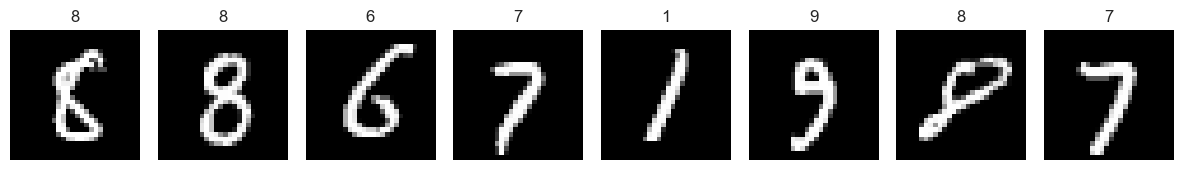

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Nsubplots=8  #Dividir en el número de imágenes que queramos mostrar en una fila
fig, ax = plt.subplots(1, Nsubplots, figsize=(12, 4), tight_layout=True)
idx = np.random.choice(len(train_set), Nsubplots) # Se seleccionan de forma aleatoria 8 índices

for k in range(Nsubplots):
    imagen, etiqueta = train_set[idx[k]]
    ax[k].imshow(imagen[0, :, :].numpy(), cmap="Greys_r")
    ax[k].axis('off') # Se eliminan los ejes para que sólo se vean los números.
    ax[k].set_title(etiqueta)



# 3. Definición del modelo neuronal

La RNA se define como una clase perteneciente a *nn.Module*.

En el constructor __init__ se definen las capas de las cuales constará el modelo.

En el método **forward** se especifica la interconexión de las capas.


Esta red consta de una capa oculta con $N_{ocultas}$ unidades y una capa de salida con 10 unidades, una unidad por cada una de las posibles clases (en nuestro caso los dígitos del 0 al 9).

Se aplicará la función de activación ReLU en la capa oculta, y la función Softmax para la capa de salida.

La capa oculta recibe los datos de entrada a través del tensor, que tiene un tamaño 28x28, por tanto la capa tendrá un tamaño de entrada de 28x28 y un tamaño de salida de $N_{ocultas}$.

La capa de salida recibirá los datos de la capa oculta con un tamaño de $N_{ocultas}$ y su salida será igual al número de clases, en nuestro caso 10 clases.

## Pregunta 2:
¿Tiene sentido cambiar el número de unidades en la capa de salida?
¿Y en la capa oculta?

En la capa de salida no tiene sentido, pues los diferentes resultados de la clasificación son los que son (10) y hay una unidad por salida, por lo que no tiene sentido añadir más unidades. En la capa oculta si que tiene sentido modificar el número de unidades, ya sea aumentarlo para potencialmente mejorar la exactitud de la red o bien disminuirla para evitar overfittin.

In [10]:
class MLP(nn.Module):
    def __init__(self, Nocultas):
        super(MLP, self).__init__()
        self.Nocultas = Nocultas
        self.fc1 = nn.Linear(28*28, self.Nocultas) # Capa oculta
        self.fc2 = nn.Linear(self.Nocultas, 10) # Capa de salida

    def forward(self, x):
        x = x.view(-1, 28*28) # Transforma las imágenes de tamaño (n, 28, 28) a (n, 784)
        x = F.relu(self.fc1(x)) # Función de activación relu en la salida de la capa oculta
        x = F.softmax(self.fc2(x), dim=1) # Función de activación softmax en la salida de la capa oculta
        return x

In [11]:
# Versión equivalente al modelo de arriba. Tal y como se ha visto en seminarios, es la otra forma posible de definir una red.
# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(28*28, 128),
#     nn.ReLU(),
#     nn.Linear(128, 10),
#     nn.Softmax(dim=1)
# )

Una vez definida la clase MLP, que contiene el modelo neuronal deseado, se crea un objeto de dicha clase, la medida específica para calcular el error, en este caso  y el optimizador que vamos a utilizar para ajustar los pesos de la red. En nuestro caso será el descenso por gradiente estocástico el optimizador que utilizaremos con un ratio de aprendizaje de 0.1 y un momento de 0.9. Recuerde que el momento o *momentum*, es un parámetro que facilita la convergencia a la solución de forma más rápida.

In [34]:
model = MLP(128)
lossFun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# 4. Entrenamiento del modelo

El proceso de entrenamiento consiste en presentar a la red un número dado de veces ($num_{epochs}$) los datos de entrenamiento para que esta vaya ajustando sus pesos.

Después de cada ciclo de entrenamiento se evalúa la salida predicha por el modelo, es decir, se calcula el error cometido entre la predicción y la clase real conocida, tanto con los datos de entrenamiento como con los datos de test.

Del siguiente código lo importante es que se familiarice con el proceso de entrenamiento de la red. Es decir, la propagación hacia adelante, el cálculo del error y la propagación hacia atrás de los errores para ajustar los pesos.

In [35]:
lossTrain_list         = []
lossVal_list      = []
accTrain_list     = []
accVal_list       = []
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    Ntrain=0   #numero total de datos de entrenamiento
    correct=0
    # ENTRENAMIENTO con datos de TRAIN

    for images, targets in train_loader:
        optimizer.zero_grad()                      # 1. Inicializa gradiente
        outputs = model(images)                    # 2. Propagación hacia adelante. Obtención de la salida
        loss = lossFun(outputs, targets)           # 3. Cálculo del error
        loss.backward()                            # 4. Propagación hacia atrás de los errores.
        optimizer.step()                           #    Actualiza parámetros.

        predicted = torch.argmax(outputs.data, 1)  # salida predicha
        Ntrain += len(targets)                     # total datos de entrenamiento
        correct += (predicted == targets).sum()    # número de predicciones correctas

    # calcula Accuracy o precisión de entrenamiento
    accTrain = float(correct) / float(Ntrain)
    # guarda resultados de cada epoch
    lossTrain_list.append(loss.item())
    accTrain_list.append(accTrain)

    # VALIDACIÓN con los datos de TEST
    correct = 0
    NVal  = 0
    with torch.no_grad():
        for images, targets in test_loader:
            outputs = model(images)                     # Aplica Modelo a datos de Test
            lossVal    = lossFun(outputs, targets)
            predicted = torch.max(outputs.data, 1)[1]   # salida calculada
            NVal += len(targets)                        # total datos de test
            correct += (predicted == targets).sum()     # número de predicciones incorrectas

    # calcula la precisión de Validación
    accVal = float(correct) / float(NVal)
    accVal_list.append(accVal)
    lossVal_list.append(lossVal.item())

    #Resultados por epoch
    print(f'Epoch: {epoch} | CrossEntropyLoss: {loss.data:.4f} | Train Accuracy: {accTrain:.4f} | Validation Accuracy: {accVal:.4f}')

 10%|█         | 1/10 [00:07<01:04,  7.19s/it]

Epoch: 0 | CrossEntropyLoss: 1.6117 | Train Accuracy: 0.7717 | Validation Accuracy: 0.8498


 20%|██        | 2/10 [00:11<00:46,  5.77s/it]

Epoch: 1 | CrossEntropyLoss: 1.5493 | Train Accuracy: 0.8961 | Validation Accuracy: 0.9283


 30%|███       | 3/10 [00:17<00:40,  5.76s/it]

Epoch: 2 | CrossEntropyLoss: 1.5438 | Train Accuracy: 0.9373 | Validation Accuracy: 0.9415


 40%|████      | 4/10 [00:25<00:39,  6.61s/it]

Epoch: 3 | CrossEntropyLoss: 1.4890 | Train Accuracy: 0.9482 | Validation Accuracy: 0.9519


 50%|█████     | 5/10 [00:32<00:34,  6.82s/it]

Epoch: 4 | CrossEntropyLoss: 1.4923 | Train Accuracy: 0.9564 | Validation Accuracy: 0.9546


 60%|██████    | 6/10 [00:43<00:31,  7.97s/it]

Epoch: 5 | CrossEntropyLoss: 1.4860 | Train Accuracy: 0.9617 | Validation Accuracy: 0.9612


 70%|███████   | 7/10 [00:52<00:25,  8.47s/it]

Epoch: 6 | CrossEntropyLoss: 1.4714 | Train Accuracy: 0.9660 | Validation Accuracy: 0.9639


 80%|████████  | 8/10 [01:03<00:18,  9.15s/it]

Epoch: 7 | CrossEntropyLoss: 1.5139 | Train Accuracy: 0.9697 | Validation Accuracy: 0.9663


 90%|█████████ | 9/10 [01:14<00:09,  9.70s/it]

Epoch: 8 | CrossEntropyLoss: 1.4775 | Train Accuracy: 0.9721 | Validation Accuracy: 0.9682


100%|██████████| 10/10 [01:19<00:00,  7.95s/it]

Epoch: 9 | CrossEntropyLoss: 1.4907 | Train Accuracy: 0.9746 | Validation Accuracy: 0.9694


# 4. Visualización de resultados



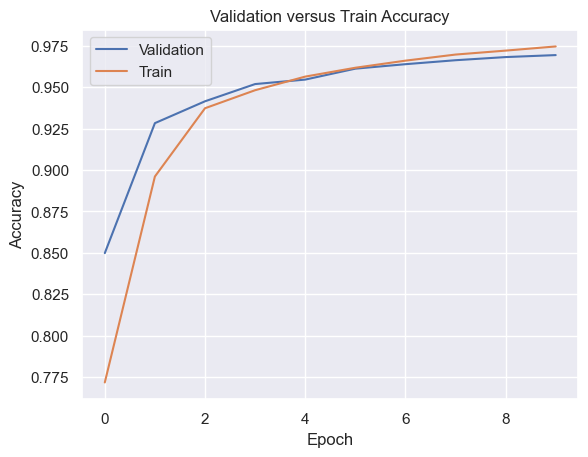

In [36]:
sns.lineplot(x=list(range(num_epochs)), y=accVal_list, label="Validation")
sns.lineplot(x=list(range(num_epochs)), y=accTrain_list, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation versus Train Accuracy")
plt.show()

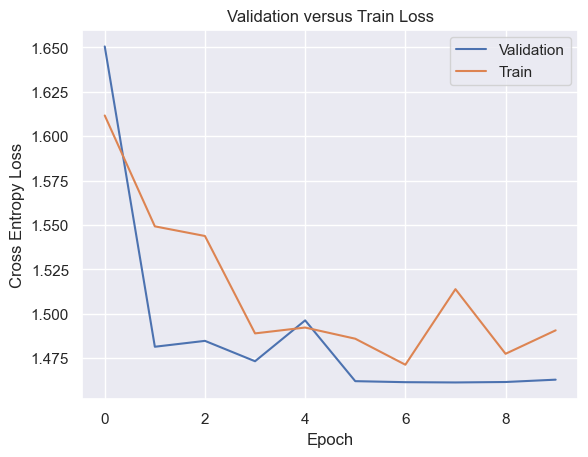

In [37]:
sns.lineplot(x=range(num_epochs), y=lossVal_list, label="Validation")
sns.lineplot(x=range(num_epochs), y=lossTrain_list, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Validation versus Train Loss")
plt.show()

# Taller

In [16]:
# No le preste atención a esta función. De momento, simplemente ejececute esta celda.
def Imagen(imagen, param = False):
    imagen = ImageOps.grayscale(imagen)
    if param == True:
        imagen = ImageOps.invert(imagen)
    imagen = np.array(imagen)
    imagen = torch.Tensor(imagen).view(-1, 784)
    return imagen

Tiene a su disposición en el campus virtual un conjunto de dígitos manuscritos que no se encuentran en el conjunto original del MNIST. Suba el zip mediante el menú desplegable de la izquierda y tras esto, ejecute la siguiente celda. Así, se descomprimirá la carpeta de las imágenes en su directorio de trabajo.

In [18]:
!unzip MNIST.zip

Archive:  MNIST.zip
   creating: Imagenes/
  inflating: Imagenes/0.tif          
  inflating: Imagenes/1.tif          
  inflating: Imagenes/2.tif          
  inflating: Imagenes/3.tif          
  inflating: Imagenes/4.tif          
  inflating: Imagenes/5.tif          
  inflating: Imagenes/6.tif          
  inflating: Imagenes/7.tif          
  inflating: Imagenes/8.tif          
  inflating: Imagenes/9.tif          


¿Considera que funcionará mejor o peor? Teniendo en cuenta que se han obtenido valores de exactitud por encima del $90\%$, debería funcionar igual de bien, ¿verdad? Sin embargo, comprobará que en la práctica no tiene por qué ser así.

Para ello, es importante tener en cuenta cómo ha sido entrenada la red. Si ejecuta el código expuesto abajo, ¿qué valor de exactitud obtiene? ¿Era el esperado?

Imagenes/6.tif
Imagenes/7.tif
Imagenes/1.tif
Imagenes/9.tif
Imagenes/4.tif
Imagenes/2.tif
Imagenes/0.tif
Imagenes/8.tif
Imagenes/3.tif
Imagenes/5.tif


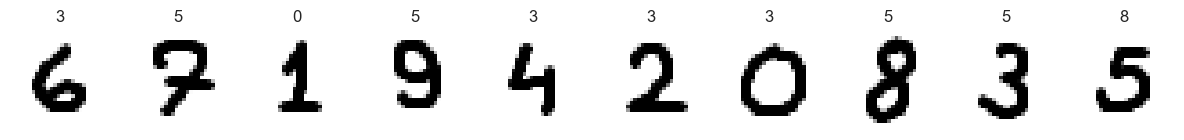

In [38]:
aciertos = []
Nsubplots=10 #Dividir en el número de imágenes que queramos mostrar en una fila
fig, ax = plt.subplots(1, Nsubplots, figsize=(12, 4), tight_layout=True)
idx = np.random.choice(len(train_set), Nsubplots) # Se seleccionan de forma aleatoria 8 índices

k = 0
for path in Path("Imagenes").rglob("*.tif"):
    print(path)

    imagen = Image.open(path)
    target = str(path).split("\\")[-1]
    target = re.search('\d', target)[0]

    imagen = Imagen(imagen)
    y_hat = model(imagen)
    y_hat = torch.argmax(y_hat)
    aciertos.append(int(y_hat == int(target)))
    ax[k%len(ax)].imshow(imagen.view(28,28).numpy(), cmap="Greys_r")
    ax[k%len(ax)].axis('off') # Se eliminan los ejes para que sólo se vean los números.
    ax[k%len(ax)].set_title(str(y_hat.item()))
    k += 1


Abra una aplicación como puede ser Paint, Gimp o similar. Pruebe a dibujar varios de los números que se intentan clasificar. Para nombrar a los ficheros, incluya al menos el número a predecir en el nombre del archivo. Ese nombre se tomará para determinar la clase de la imagen. Puede crear una carpeta propia "Imagenes2". Si no tiene suficientes, puede pedirle a su compañero que le facilite los números que ha creado.

Imagenes2/3.png
Imagenes2/9.png
Imagenes2/7.png
Imagenes2/2.png
Imagenes2/5.png
Imagenes2/1.png
Imagenes2/4.png
Imagenes2/8.png
Imagenes2/6.png
Imagenes2/0.png


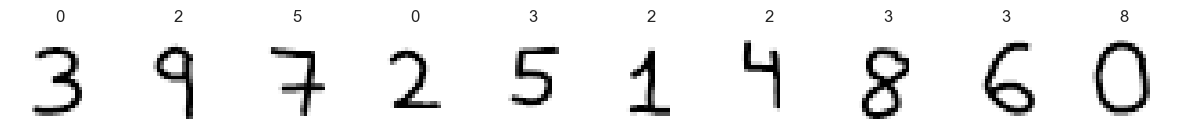

In [39]:
aciertos = []
Nsubplots=10 #Dividir en el número de imágenes que queramos mostrar en una fila
fig, ax = plt.subplots(1, Nsubplots, figsize=(12, 4), tight_layout=True)
idx = np.random.choice(len(train_set), Nsubplots) # Se seleccionan de forma aleatoria 8 índices

k = 0
for path in Path("Imagenes2").rglob("*.png"):
    print(path)

    imagen = Image.open(path)
    target = str(path).split("\\")[-1]
    target = re.search('\d', target)[0]

    imagen = Imagen(imagen)
    y_hat = model(imagen)
    y_hat = torch.argmax(y_hat)
    aciertos.append(int(y_hat == int(target)))
    ax[k%len(ax)].imshow(imagen.view(28,28).numpy(), cmap="Greys_r")
    ax[k%len(ax)].axis('off') # Se eliminan los ejes para que sólo se vean los números.
    ax[k%len(ax)].set_title(str(y_hat.item()))
    k += 1


¿Sigue ocurriendo lo mismo?

In [ ]:
#Si, pues se ha entrenado con fondo negro y número en blanco.

¿Qué ocurre si a la función de Imagen le pasa como parámetro un _True_? ¿Se obtiene el mismo resultado?

Imagenes2/3.png
Imagenes2/9.png
Imagenes2/7.png
Imagenes2/2.png
Imagenes2/5.png
Imagenes2/1.png
Imagenes2/4.png
Imagenes2/8.png
Imagenes2/6.png
Imagenes2/0.png


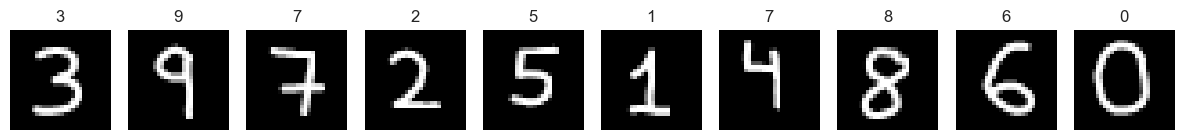

In [40]:
aciertos = []
Nsubplots=10#Dividir en el número de imágenes que queramos mostrar en una fila
fig, ax = plt.subplots(1, Nsubplots, figsize=(12, 4), tight_layout=True)
idx = np.random.choice(len(train_set), Nsubplots) # Se seleccionan de forma aleatoria 8 índices

k = 0
for path in Path("Imagenes2").rglob("*.png"):
    print(path)

    imagen = Image.open(path)
    target = str(path).split("\\")[-1]
    target = re.search('\d', target)[0]

    imagen = Imagen(imagen, True)
    y_hat = model(imagen)
    y_hat = torch.argmax(y_hat)
    aciertos.append(int(y_hat == int(target)))
    ax[k%len(ax)].imshow(imagen.view(28,28).numpy(), cmap="Greys_r")
    ax[k%len(ax)].axis('off') # Se eliminan los ejes para que sólo se vean los números.
    ax[k%len(ax)].set_title(str(y_hat.item()))
    k += 1


¿Recuerda qué forma tenían los datos de entrenamiento? Cómo funcione el modelo depende de cómo haya sido entrenado y, por eso suele ser necesario realizar un procesamiento previo de los datos, como en este caso. Si la red neuronal se ha entrenado con el fondo negro y los números en blanco, la entrada debe seguir el mismo formato, si no, como en el caso anterior, la red no funcionará como se espera.


## MATRIZ DE CONFUSIÓN

In [41]:
!pip install torchmetrics

Vea ahora las siguientes celdas. En ellas se muestra cuántas imágenes hay de una clase en concreta, en primer lugar para el conjunto de entrenamiento y, posteriormente para el conjunto de test

In [42]:
valor, freq = np.unique(train_set.targets.numpy(), return_counts=True)
for pair in zip(valor, freq):
    print(f"De la clase {pair[0]} existen {pair[1]} imágenes")

De la clase 0 existen 5923 imágenes
De la clase 1 existen 6742 imágenes
De la clase 2 existen 5958 imágenes
De la clase 3 existen 6131 imágenes
De la clase 4 existen 5842 imágenes
De la clase 5 existen 5421 imágenes
De la clase 6 existen 5918 imágenes
De la clase 7 existen 6265 imágenes
De la clase 8 existen 5851 imágenes
De la clase 9 existen 5949 imágenes


In [43]:
valor, freq = np.unique(test_set.targets.numpy(), return_counts=True)
for pair in zip(valor, freq):
    print(f"De la clase {pair[0]} existen {pair[1]} imágenes")

De la clase 0 existen 980 imágenes
De la clase 1 existen 1135 imágenes
De la clase 2 existen 1032 imágenes
De la clase 3 existen 1010 imágenes
De la clase 4 existen 982 imágenes
De la clase 5 existen 892 imágenes
De la clase 6 existen 958 imágenes
De la clase 7 existen 1028 imágenes
De la clase 8 existen 974 imágenes
De la clase 9 existen 1009 imágenes


¿Considera que las clases están balanceadas?

Si, están balanceadas aproximadamente, lo cual favorece menos el overfittin

In [44]:
from torchmetrics import ConfusionMatrix

total = 0
correct = 0

test_loader = torch.utils.data.DataLoader(test_set,
                 batch_size=10000,
                 shuffle=False,
                 drop_last=False)

for images, targets in test_loader:
    #convierte datos del tensor a variables del auto-grad
    images = Variable(images)
    targets = Variable(targets)

    # forward pass
    outTest = model(images.view(images.size(0), -1))

    # calculate total accuracy
    predicted = torch.max(outTest.data, 1)[1]
    #predicted = outTest.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()
    confmat = ConfusionMatrix(task="multiclass",num_classes=10)
    confmat(predicted, targets)



print(f"Porcentaje de patrones bien clasificados (Accuracy): {100 * correct / total:.2f}%")

confmat = ConfusionMatrix(task="multiclass",num_classes=10)
confmat = np.array(confmat(predicted, targets))
pd.DataFrame(confmat)

Porcentaje de patrones bien clasificados (Accuracy): 96.94%


/tmp/ipykernel_5502/1779733338.py:32: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  confmat = np.array(confmat(predicted, targets))


,0,1,2,3,4,5,6,7,8,9
0,965,0,2,3,0,3,2,2,3,0
1,0,1113,3,4,0,1,4,2,8,0
2,7,1,998,5,5,0,2,7,7,0
3,1,0,2,978,0,5,1,9,6,8
4,1,0,5,0,957,0,2,3,2,12
5,6,1,0,5,2,854,9,1,9,5
6,6,2,1,1,7,4,931,1,5,0
7,0,6,16,3,2,1,0,994,2,4
8,4,1,2,6,4,3,5,5,940,4
9,4,4,1,10,12,2,1,4,7,964


En función de esa tabla que representa la matriz de confusión. ¿Qué número cree que es capaz de predecir mejor la red? ¿Y peor? ¿Cómo se podría extraer esa información?

Aproximadamente predice todos igual de bien, aunque si hubiera que decir el mejor sería el 1 y el peor es el 9. Dividiendo el número de verdaderos positivos entre imágenes totales.

Para repasar los conceptos que se han visto en clase, le recomendamos visitar la siguiente dirección [Playground de Tensorflow](https://playground.tensorflow.org/) Aquí podrá ver varios ejemplos y podrá interactuar sin tener que implementar nada. Familiarícese con algunos ejemplos y compruebe si las distintas pruebas que realiza, se corresponden con lo que esperaba para cada uno de ellos.

# PRÁCTICAS
1. Entrena durante más epochs, por ejemplo 100 y visualiza los resultados.
2. Cambia el número de capas (1 o 2) y el número de unidades ocultas:
  A) 25 unidades ocultas
  B) 500 unidades ocultas
  Compara los resultados entre los distintos modelos en función de la precisión de los resultados.

### UTILIDADES para guardar datos del entrenamiento

¿Qué ocurre cuando tenemos un modelo entrenado y queremos volver a utilizarlo? ¿Debemos entrenar el modelo de nuevo cada vez que se quiera hacer una predicción? No, no hace falta. Basta con guardar los parámetros que definen el modelo, como los pesos o los bias. A partir de ahí, es posible cargar el modelo y comenzar a hacer predicciones con el modelo ya entrenado.

Esto resulta de gran utilidad para, por ejemplo, llevar un modelo a un producto final, como puede ser una aplicación web, una app móvil, un modelo de detección de SPAM, etc.

In [47]:
torch.save(model.state_dict(), 'MODELO CON 128 UNIDADES') # es necesario especificar un path

In [48]:
model2 = MLP(128) #Generamos un nuevo modelo
model2.load_state_dict(torch.load("MODELO CON 128 UNIDADES")) #Cargamos los pesos anteriores

/tmp/ipykernel_5502/3662397257.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("MODELO CON 128 UNIDADES")) #Cargamos los pesos anterior

<All keys matched successfully>

Pruebe a predecir algunas de las imágenes propias que ha incorporado antes. ¿Funciona? ¿Se obtiene la misma predicción?

  3%|▎         | 1/30 [00:05<02:25,  5.03s/it]

Epoch: 0 | CrossEntropyLoss: 1.5970 | Train Accuracy: 0.7363 | Validation Accuracy: 0.8373


  7%|▋         | 2/30 [00:13<03:16,  7.03s/it]

Epoch: 1 | CrossEntropyLoss: 1.5515 | Train Accuracy: 0.8918 | Validation Accuracy: 0.9260


 10%|█         | 3/30 [00:18<02:43,  6.05s/it]

Epoch: 2 | CrossEntropyLoss: 1.5373 | Train Accuracy: 0.9276 | Validation Accuracy: 0.9368


 13%|█▎        | 4/30 [00:22<02:15,  5.19s/it]

Epoch: 3 | CrossEntropyLoss: 1.5238 | Train Accuracy: 0.9364 | Validation Accuracy: 0.9386


 17%|█▋        | 5/30 [00:29<02:31,  6.06s/it]

Epoch: 4 | CrossEntropyLoss: 1.5266 | Train Accuracy: 0.9425 | Validation Accuracy: 0.9413


 20%|██        | 6/30 [00:40<03:01,  7.58s/it]

Epoch: 5 | CrossEntropyLoss: 1.4986 | Train Accuracy: 0.9474 | Validation Accuracy: 0.9472


 23%|██▎       | 7/30 [00:48<02:59,  7.80s/it]

Epoch: 6 | CrossEntropyLoss: 1.5518 | Train Accuracy: 0.9519 | Validation Accuracy: 0.9508


 27%|██▋       | 8/30 [00:54<02:40,  7.31s/it]

Epoch: 7 | CrossEntropyLoss: 1.4870 | Train Accuracy: 0.9546 | Validation Accuracy: 0.9490


 30%|███       | 9/30 [01:03<02:40,  7.65s/it]

Epoch: 8 | CrossEntropyLoss: 1.5275 | Train Accuracy: 0.9577 | Validation Accuracy: 0.9498


 33%|███▎      | 10/30 [01:10<02:28,  7.41s/it]

Epoch: 9 | CrossEntropyLoss: 1.5169 | Train Accuracy: 0.9605 | Validation Accuracy: 0.9566


 37%|███▋      | 11/30 [01:17<02:21,  7.42s/it]

Epoch: 10 | CrossEntropyLoss: 1.5055 | Train Accuracy: 0.9617 | Validation Accuracy: 0.9556


 40%|████      | 12/30 [01:23<02:04,  6.90s/it]

Epoch: 11 | CrossEntropyLoss: 1.4786 | Train Accuracy: 0.9635 | Validation Accuracy: 0.9581


 43%|████▎     | 13/30 [01:31<02:05,  7.37s/it]

Epoch: 12 | CrossEntropyLoss: 1.5273 | Train Accuracy: 0.9650 | Validation Accuracy: 0.9584


 47%|████▋     | 14/30 [01:40<02:04,  7.77s/it]

Epoch: 13 | CrossEntropyLoss: 1.4871 | Train Accuracy: 0.9663 | Validation Accuracy: 0.9597


 50%|█████     | 15/30 [01:50<02:05,  8.40s/it]

Epoch: 14 | CrossEntropyLoss: 1.4900 | Train Accuracy: 0.9671 | Validation Accuracy: 0.9593


 53%|█████▎    | 16/30 [01:54<01:38,  7.05s/it]

Epoch: 15 | CrossEntropyLoss: 1.5178 | Train Accuracy: 0.9682 | Validation Accuracy: 0.9588


 57%|█████▋    | 17/30 [01:59<01:24,  6.50s/it]

Epoch: 16 | CrossEntropyLoss: 1.5005 | Train Accuracy: 0.9693 | Validation Accuracy: 0.9582


 60%|██████    | 18/30 [02:05<01:14,  6.24s/it]

Epoch: 17 | CrossEntropyLoss: 1.4806 | Train Accuracy: 0.9708 | Validation Accuracy: 0.9608


 63%|██████▎   | 19/30 [02:13<01:16,  6.96s/it]

Epoch: 18 | CrossEntropyLoss: 1.4987 | Train Accuracy: 0.9714 | Validation Accuracy: 0.9583


 67%|██████▋   | 20/30 [02:17<01:00,  6.10s/it]

Epoch: 19 | CrossEntropyLoss: 1.4770 | Train Accuracy: 0.9719 | Validation Accuracy: 0.9615


 70%|███████   | 21/30 [02:27<01:03,  7.04s/it]

Epoch: 20 | CrossEntropyLoss: 1.5012 | Train Accuracy: 0.9730 | Validation Accuracy: 0.9583


 73%|███████▎  | 22/30 [02:31<00:50,  6.34s/it]

Epoch: 21 | CrossEntropyLoss: 1.4735 | Train Accuracy: 0.9734 | Validation Accuracy: 0.9610


 77%|███████▋  | 23/30 [02:36<00:41,  5.89s/it]

Epoch: 22 | CrossEntropyLoss: 1.4956 | Train Accuracy: 0.9741 | Validation Accuracy: 0.9607


 80%|████████  | 24/30 [02:40<00:31,  5.27s/it]

Epoch: 23 | CrossEntropyLoss: 1.4728 | Train Accuracy: 0.9739 | Validation Accuracy: 0.9614


 83%|████████▎ | 25/30 [02:45<00:25,  5.13s/it]

Epoch: 24 | CrossEntropyLoss: 1.4760 | Train Accuracy: 0.9751 | Validation Accuracy: 0.9622


 87%|████████▋ | 26/30 [02:49<00:19,  4.98s/it]

Epoch: 25 | CrossEntropyLoss: 1.4726 | Train Accuracy: 0.9756 | Validation Accuracy: 0.9605


 90%|█████████ | 27/30 [02:58<00:17,  5.94s/it]

Epoch: 26 | CrossEntropyLoss: 1.4637 | Train Accuracy: 0.9758 | Validation Accuracy: 0.9626


 93%|█████████▎| 28/30 [03:03<00:11,  5.76s/it]

Epoch: 27 | CrossEntropyLoss: 1.5033 | Train Accuracy: 0.9762 | Validation Accuracy: 0.9618


 97%|█████████▋| 29/30 [03:09<00:05,  5.99s/it]

Epoch: 28 | CrossEntropyLoss: 1.4747 | Train Accuracy: 0.9766 | Validation Accuracy: 0.9616


100%|██████████| 30/30 [03:15<00:00,  6.52s/it]

Epoch: 29 | CrossEntropyLoss: 1.4841 | Train Accuracy: 0.9763 | Validation Accuracy: 0.9635


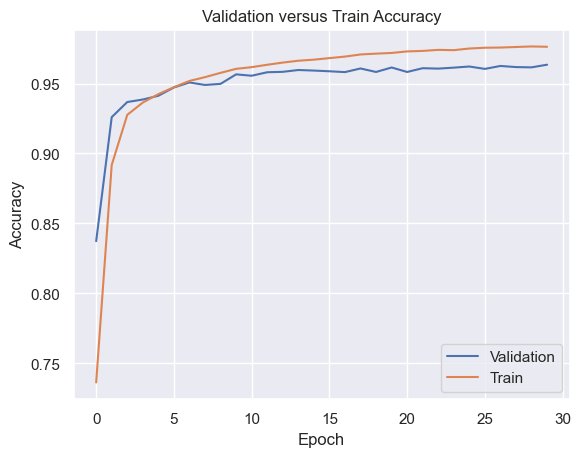

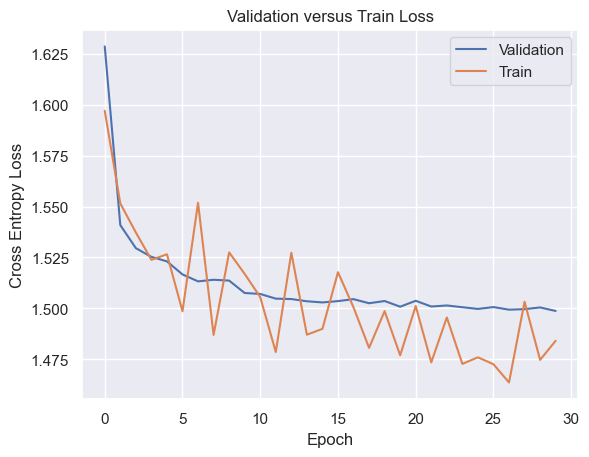

In [51]:
model = MLP(25)
lossFun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

lossTrain_list         = []
lossVal_list      = []
accTrain_list     = []
accVal_list       = []
num_epochs = 30

for epoch in tqdm(range(num_epochs)):
    Ntrain=0   #numero total de datos de entrenamiento
    correct=0
    # ENTRENAMIENTO con datos de TRAIN

    for images, targets in train_loader:
        optimizer.zero_grad()                      # 1. Inicializa gradiente
        outputs = model(images)                    # 2. Propagación hacia adelante. Obtención de la salida
        loss = lossFun(outputs, targets)           # 3. Cálculo del error
        loss.backward()                            # 4. Propagación hacia atrás de los errores.
        optimizer.step()                           #    Actualiza parámetros.

        predicted = torch.argmax(outputs.data, 1)  # salida predicha
        Ntrain += len(targets)                     # total datos de entrenamiento
        correct += (predicted == targets).sum()    # número de predicciones correctas

    # calcula Accuracy o precisión de entrenamiento
    accTrain = float(correct) / float(Ntrain)
    # guarda resultados de cada epoch
    lossTrain_list.append(loss.item())
    accTrain_list.append(accTrain)

    # VALIDACIÓN con los datos de TEST
    correct = 0
    NVal  = 0
    with torch.no_grad():
        for images, targets in test_loader:
            outputs = model(images)                     # Aplica Modelo a datos de Test
            lossVal    = lossFun(outputs, targets)
            predicted = torch.max(outputs.data, 1)[1]   # salida calculada
            NVal += len(targets)                        # total datos de test
            correct += (predicted == targets).sum()     # número de predicciones incorrectas

    # calcula la precisión de Validación
    accVal = float(correct) / float(NVal)
    accVal_list.append(accVal)
    lossVal_list.append(lossVal.item())

    #Resultados por epoch
    print(f'Epoch: {epoch} | CrossEntropyLoss: {loss.data:.4f} | Train Accuracy: {accTrain:.4f} | Validation Accuracy: {accVal:.4f}')

sns.lineplot(x=list(range(num_epochs)), y=accVal_list, label="Validation")
sns.lineplot(x=list(range(num_epochs)), y=accTrain_list, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation versus Train Accuracy")
plt.show()

sns.lineplot(x=range(num_epochs), y=lossVal_list, label="Validation")
sns.lineplot(x=range(num_epochs), y=lossTrain_list, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Validation versus Train Loss")
plt.show()

Imagenes2/3.png
Imagenes2/9.png
Imagenes2/7.png
Imagenes2/2.png
Imagenes2/5.png
Imagenes2/1.png
Imagenes2/4.png
Imagenes2/8.png
Imagenes2/6.png
Imagenes2/0.png


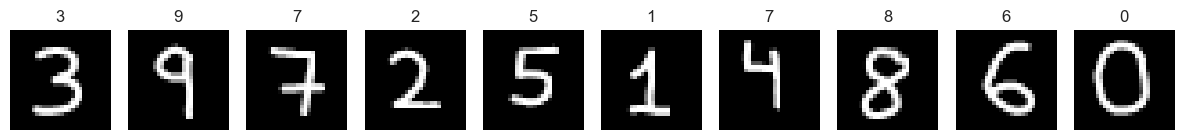

In [52]:
aciertos = []
Nsubplots=10#Dividir en el número de imágenes que queramos mostrar en una fila
fig, ax = plt.subplots(1, Nsubplots, figsize=(12, 4), tight_layout=True)
idx = np.random.choice(len(train_set), Nsubplots) # Se seleccionan de forma aleatoria 8 índices

k = 0
for path in Path("Imagenes2").rglob("*.png"):
    print(path)

    imagen = Image.open(path)
    target = str(path).split("\\")[-1]
    target = re.search('\d', target)[0]

    imagen = Imagen(imagen, True)
    y_hat = model(imagen)
    y_hat = torch.argmax(y_hat)
    aciertos.append(int(y_hat == int(target)))
    ax[k%len(ax)].imshow(imagen.view(28,28).numpy(), cmap="Greys_r")
    ax[k%len(ax)].axis('off') # Se eliminan los ejes para que sólo se vean los números.
    ax[k%len(ax)].set_title(str(y_hat.item()))
    k += 1

Si, predice igual de bien.